In [99]:
!pip install kaucherpy
import numpy as np
import kaucherpy as kp
import matplotlib.pyplot as plt
import random

You should consider upgrading via the '/home/danil/PycharmProjects/pythonProject/venv/bin/python -m pip install --upgrade pip' command.


# **Kaucher transitions**

In [100]:
def get_Kaucher_mat(A_inf, A_sup):
  n = A_inf.shape[0]
  return np.array([[kp.Kaucher(A_inf[i][j], A_sup[i][j]) for j in range(n)] for i in range(n)])

def get_inv_Kaucher_mat(A):
  n = A.shape[0]
  A_inf = np.array([[A[i][j].lower for j in range(n)] for i in range(n)])
  A_sup = np.array([[A[i][j].upper for j in range(n)] for i in range(n)])
  return (A_inf, A_sup)

def get_Kaucher_vec(b_inf, b_sup):
  n = b_inf.shape[0]
  return np.array([kp.Kaucher(b_inf[i], b_sup[i]) for i in range(n)])

def get_inv_Kaucher_vec(b):
  n = b.shape[0]
  b_inf = np.array([b[i].lower for i in range(n)])
  b_sup = np.array([b[i].upper for i in range(n)])
  return (b_inf, b_sup)

def get_mid_Kaucher_vec(b):
  b_mid = np.zeros(b.shape[0])
  for i in range(b.shape[0]):
    b_mid[i] = (b[i].upper + b[i].lower) / 2
  return b_mid

# **SubDiff methods**

In [101]:
def _get_sti_vec(vec_inf, vec_sup):
  return np.append(-vec_inf, vec_sup)

def _get_inv_sti_vec(vec):
  n = vec.shape[0] // 2
  vec_inf = -vec[:n]
  vec_sup = vec[n:]
  return (vec_inf, vec_sup)

def _get_sign_block_matrix(mat):
  mat_pos = mat.copy()
  mat_neg = mat.copy()
  mat_pos[mat_pos < 0] = 0
  mat_neg[mat_neg > 0] = 0
  return np.block([[mat_pos, -mat_neg],
                  [-mat_neg, mat_pos]])
  
def _get_x0(C_inf, C_sup, d_inf, d_sup):
  C_mid_blocked = _get_sign_block_matrix((C_sup + C_inf) / 2)
  d_sti = _get_sti_vec(d_inf, d_sup)
  return np.linalg.solve(C_mid_blocked, d_sti)

def _Gxk(C, y, d):
  y_inv = get_Kaucher_vec(*_get_inv_sti_vec(y))
  dot_prod = C.dot(y_inv)
  sti_prod = _get_sti_vec(*get_inv_Kaucher_vec(dot_prod))
  return sti_prod - _get_sti_vec(*get_inv_Kaucher_vec(d))
  
def _Dxk(A, x):
  n = A.shape[0]
  D = np.zeros((2 * n, 2 * n))

  for i in range(n):
    for j in range(n):
      xinf = x[j].lower
      xsup = x[j].upper
      ainf = A[i][j].lower
      asup = A[i][j].upper

      k = 0
      m = 0

      if ainf * asup > 0:
        if ainf > 0:
          k = 0
        else:
          k = 2
      else:
        if ainf < asup:
          k = 1
        else:
          k = 3
      
      if xinf * xsup > 0:
        if xinf > 0:
          m = 1
        else:
          m = 3
      else:
        if xinf <= xsup:
          m = 2
        else:
          m = 4

      case = 4 * k + m

      if case == 1:
        D[i][j] = ainf
        D[i + n][j + n] = asup
      elif case == 2:
        D[i][j] = asup
        D[i + n][j + n] = asup
      elif case == 3:
        D[i][j] = asup
        D[i + n][j + n] = ainf
      elif case == 4:
        D[i][j] = ainf
        D[i + n][j + n] = ainf
      elif case == 5:
        D[i][j + n] = ainf
        D[i + n][j + n] = asup
      elif case == 6:
        if ainf * xsup < asup * xinf:
          D[i][j + n] = ainf
        else:
          D[i][j] = asup
        if ainf * xinf > asup * xsup:
          D[i + n][j] = ainf
        else:
          D[i + n][j + n] = asup
      elif case == 7:
        D[i][j] = asup
        D[i + n][j] = ainf
      elif case == 8 or case == 9:
        D[i][j + n] = ainf
        D[i + n][j] = asup
      elif case == 10:
        D[i][j + n] = ainf
        D[i + n][j] = ainf
      elif case == 11:
        D[i][j + n] = asup
        D[i + n][j] = ainf
      elif case == 12:
        D[i][j + n] = asup
        D[i + n][j] = asup
      elif case == 13:
        D[i][j] = ainf
        D[i + n][j] = asup
      elif case == 14 or case == 15:
        D[i][j + n] = asup
        D[i + n][j + n] = ainf
      elif case == 16:
        if ainf * xinf > asup * xsup:
          D[i][j] = ainf
        else:
          D[i][j + n] = -asup
        if ainf * xsup < asup * xinf:
          D[i + n][j + n] = ainf
        else:
          D[i + n][j] = asup
  return D


def _get_sti_vec(vec_inf, vec_sup):
  return np.append(-vec_inf, vec_sup)


def _get_inv_sti_vec(vec):
  n = vec.shape[0] // 2
  vec_inf = -vec[:n]
  vec_sup = vec[n:]
  return (vec_inf, vec_sup)


def _get_sign_block_matrix(mat):
  mat_pos = mat.copy()
  mat_neg = mat.copy()
  mat_pos[mat_pos < 0] = 0
  mat_neg[mat_neg > 0] = 0
  return np.block([[mat_pos, -mat_neg],
                   [-mat_neg, mat_pos]])


def _get_x0(C_inf, C_sup, d_inf, d_sup):
  C_mid_blocked = _get_sign_block_matrix((C_sup + C_inf) / 2)
  d_sti = _get_sti_vec(d_inf, d_sup)
  return np.linalg.solve(C_mid_blocked, d_sti)


def _Gxk(C, y, d):
  y_inv = get_Kaucher_vec(*_get_inv_sti_vec(y))
  dot_prod = C.dot(y_inv)
  sti_prod = _get_sti_vec(*get_inv_Kaucher_vec(dot_prod))
  return sti_prod - _get_sti_vec(*get_inv_Kaucher_vec(d))


def _Dxk(A, x):
  n = A.shape[0]
  D = np.zeros((2 * n, 2 * n))

  for i in range(n):
    for j in range(n):
      xinf = x[j].lower
      xsup = x[j].upper
      ainf = A[i][j].lower
      asup = A[i][j].upper

      k = 0
      m = 0

      if ainf * asup > 0:
        if ainf > 0:
          k = 0
        else:
          k = 2
      else:
        if ainf < asup:
          k = 1
        else:
          k = 3

      if xinf * xsup > 0:
        if xinf > 0:
          m = 1
        else:
          m = 3
      else:
        if xinf <= xsup:
          m = 2
        else:
          m = 4

      case = 4 * k + m

      if case == 1:
        D[i][j] = ainf
        D[i + n][j + n] = asup
      elif case == 2:
        D[i][j] = asup
        D[i + n][j + n] = asup
      elif case == 3:
        D[i][j] = asup
        D[i + n][j + n] = ainf
      elif case == 4:
        D[i][j] = ainf
        D[i + n][j + n] = ainf
      elif case == 5:
        D[i][j + n] = ainf
        D[i + n][j + n] = asup
      elif case == 6:
        if ainf * xsup < asup * xinf:
          D[i][j + n] = ainf
        else:
          D[i][j] = asup
        if ainf * xinf > asup * xsup:
          D[i + n][j] = ainf
        else:
          D[i + n][j + n] = asup
      elif case == 7:
        D[i][j] = asup
        D[i + n][j] = ainf
      elif case == 8 or case == 9:
        D[i][j + n] = ainf
        D[i + n][j] = asup
      elif case == 10:
        D[i][j + n] = ainf
        D[i + n][j] = ainf
      elif case == 11:
        D[i][j + n] = asup
        D[i + n][j] = ainf
      elif case == 12:
        D[i][j + n] = asup
        D[i + n][j] = asup
      elif case == 13:
        D[i][j] = ainf
        D[i + n][j] = asup
      elif case == 14 or case == 15:
        D[i][j + n] = asup
        D[i + n][j + n] = ainf
      elif case == 16:
        if ainf * xinf > asup * xsup:
          D[i][j] = ainf
        else:
          D[i][j + n] = -asup
        if ainf * xsup < asup * xinf:
          D[i + n][j + n] = ainf
        else:
          D[i + n][j] = asup
  return D


def printMatrix(A):
  print("MATRIX")
  matr = np.array(A)
  for line in matr:
    index = 0
    line = np.array(line)
    result = ""
    for elem in line:
      index += 1
      if index != 18:
        result += f"{np.round(elem, 3)} & "

    result += " \\\ "
    print(result)

def subDiff2(A_inf, A_sup, b_inf, b_sup, relax = 1, max_iter = 150, eps = 1e-5):
  C = get_Kaucher_mat(A_inf, A_sup)
  d = get_Kaucher_vec(b_inf, b_sup)

  # printMatrix(C)
  print("ITER = 0")
  x_prev = _get_x0(A_inf, A_sup, b_inf, b_sup)
  print(f"X(0) = {x_prev}")
  G = _Gxk(C, x_prev, d)
  D = _Dxk(C, get_Kaucher_vec(*_get_inv_sti_vec(x_prev)))
  print(f"Субградиент отображения: {np.linalg.solve(D, G)}")
  x_next = x_prev - np.linalg.solve(D, G)
  iter = 1

  print(f"X(ITER) = {x_next}")

  norms = []
  norms.append(np.linalg.norm(x_next - x_prev))
  print(f"isEscape? {np.linalg.norm(x_next - x_prev) >= eps}")
  print(f"|| x_next - x_prev || = {np.linalg.norm(x_next - x_prev)}")
  while iter <= max_iter and np.linalg.norm(x_next - x_prev) >= eps:
    x_prev = x_next
    G = _Gxk(C, x_prev, d)
    D = _Dxk(C, get_Kaucher_vec(*_get_inv_sti_vec(x_prev)))
    x_next = x_prev - np.linalg.solve(D, G)
    print(f"Субградиент отображения: {np.linalg.solve(D, G)}")
    print(f"X({iter + 1} = {x_next}")
    iter = iter + 1
    norms.append(np.linalg.norm(x_next - x_prev))

  return (_get_inv_sti_vec(x_next), iter, norms)


# **Plot methods**

In [102]:
def plot_norms_inf_sup(x_vec, infs, sups, filename):
  plt.figure(figsize=(15,10))
  plt.plot(x_vec, infs, label='||x_real-x_inf||')
  plt.plot(x_vec, sups, label='||x_real-x_sup||')
  plt.title('Norms of difference x_real and x_inf or x_sup')
  plt.xlabel('Submatrixes number')
  plt.ylabel('Norm')
  plt.legend()
  plt.savefig(filename)

def plot_norms_mid(x_vec, mid, filename):
  plt.figure(figsize=(15,10))
  plt.plot(x_vec, mid, label='||x_real-x_mid||')
  plt.title('Norms of difference x_real and x_mid')
  plt.xlabel('Submatrixes number')
  plt.ylabel('Norm')
  plt.legend()
  plt.savefig(filename)

def plot_norms(arr, filename):
  plt.figure()
  plt.plot(arr)
  plt.title('Norms of xk')
  plt.xlabel('Iteration')
  plt.ylabel('Norm')
  plt.savefig(filename)

def plot_xs(x_real, x_inf, x_sup, filename):
  plt.figure(figsize=(15,10))
  plt.plot(x_real, label='x_real')
  plt.plot(x_sup, label='x_sup')
  plt.plot(x_inf, label='x_inf')
  plt.title('Comparison of x_real and x_solution')
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.legend()
  plt.savefig(filename)

def plot_solutions(Ax_inf, Ax_sup, b_inf, b_sup, filename):
  plt.figure(figsize=(15,10))
  plt.plot(Ax_sup, label='A * x_sup')
  plt.plot(Ax_inf, label='A * x_inf')
  plt.plot(b_inf, label='b_inf')
  plt.plot(b_sup, label='b_sup')
  plt.title('Comparison of solved b interval, task b interval and real b value')
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.legend()
  plt.savefig(filename) 

# **Task Methods**

In [103]:
def get_sub_matrix(mat):
  n = mat.shape[1]

  idxs = random.sample(range(0, mat.shape[0]), n)
  submat = mat[idxs]

  while np.linalg.det(submat) <= 1e-8:
    idxs = random.sample(range(0, mat.shape[0]), n)
    submat = mat[idxs]

  return (submat, idxs)

def get_vector_intersection(vecs):
  for vec in vecs:
    for i in range(vec.shape[0]):
      if vec[i].lower > vec[i].upper:
        buf = vec[i].lower
        vec[i].lower = vec[i].upper
        vec[i].upper = buf

  vec_res = np.copy(vecs[0])

  for vec in vecs:
    for i in range(vec_res.shape[0]):
      vec_res[i].lower = max(vec_res[i].lower, vec[i].lower)
      vec_res[i].upper = min(vec_res[i].upper, vec[i].upper)

  return vec_res

In [104]:
def solve_task(mat_address, sub_matrix_nums, plots_address):
  A = np.loadtxt(mat_address)

  A_block = A[:A.shape[0] // 2]

  cols_nonempty = []
  for j in range(A_block.shape[1]):
    counter = 0
    for i in range(A_block.shape[0]):
      if A_block[i][j] != 0.0:
        counter = counter + 1
    if counter != 0:
      cols_nonempty.append(j)
  A_block = A_block.T[cols_nonempty].T
  x_real = np.random.uniform(2, 8, A_block.shape[1])
  b_real = A_block.dot(x_real)
  rad = np.random.uniform(0.1, 1, A_block.shape[0])
  b_inf = b_real - rad
  b_sup = b_real + rad


  x_infs = []
  x_sups = []
  for num in sub_matrix_nums:
    xs = []
    for i in range(num):
      A_subblock, idxs = get_sub_matrix(A_block)
      b_subinf = b_inf[idxs]
      b_subsup = b_sup[idxs]

      printMatrix(A_subblock)
      print(f"b_inf = {b_subinf}")
      print(f"b_sup = {b_subsup}")

      x, iter, norms = subDiff2(A_subblock, A_subblock, b_subinf, b_subsup)
      print(iter)

      xs.append(get_Kaucher_vec(x[0], x[1]))

    x_res = get_vector_intersection(xs)
    x_res_pair = get_inv_Kaucher_vec(x_res)
    x_infs.append(x_res_pair[0])
    x_sups.append(x_res_pair[1])
    plot_solutions(*get_inv_Kaucher_vec(A_block.dot(x_res)), b_inf, b_sup, "sols_" + str(num) + "_mats_" + plots_address + ".png")
    plot_xs(x_real, *get_inv_Kaucher_vec(x_res), "xs_" + str(num) + "_mats_" + plots_address + ".png")
  
  plot_norms_inf_sup(sub_matrix_nums, [np.linalg.norm(x_inf - x_real) for x_inf in x_infs], 
                     [np.linalg.norm(x_sup - x_real) for x_sup in x_infs], "xinf_xsup_" + plots_address + ".png")
  plot_norms_mid(sub_matrix_nums, [np.linalg.norm((x_infs[i] + x_sups[i]) / 2 - x_real) for i in range(len(x_infs))], "xmid_" + plots_address + ".png")

# **Task**

MATRIX
0.0 & 0.0 & 0.0 & 0.0 & 0.77 & 0.267 & 0.0 & 0.0 & 0.0 & 0.0 & 0.158 & 0.267 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 &  \\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.27 & 0.0 & 0.0 & 0.0 & 0.0 & 0.684 & 0.262 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 &  \\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.074 & 0.184 & 0.132 & 0.184 & 0.184 & 0.184 & 0.11 & 0.0 & 0.235 & 0.184 & 0.184 & 0.184 & 0.008 &  \\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.054 & 0.188 & 0.0 & 0.247 & 0.208 & 0.195 & 0.136 & 0.0 & 0.0 & 0.36 & 0.208 & 0.195 & 0.023 &  \\ 
0.0 & 0.0 & 0.0 & 0.015 & 0.199 & 0.191 & 0.0 & 0.0 & 0.742 & 0.204 & 0.0 & 0.0 & 0.0 & 0.0 & 0.05 & 0.219 & 0.199 &  \\ 
0.0 & 0.362 & 0.467 & 0.382 & 0.36 & 0.35 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 &  \\ 
0.0 & 0.0 & 0.0 & 0.021 & 0.19 & 0.186 & 0.0 & 0.459 & 0.293 & 0.179 & 0.0 & 0.0 & 0.0 & 0.0 & 0.17 & 0.199 & 0.19 &  \\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.023 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.099 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 &  \\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.203 & 0.0

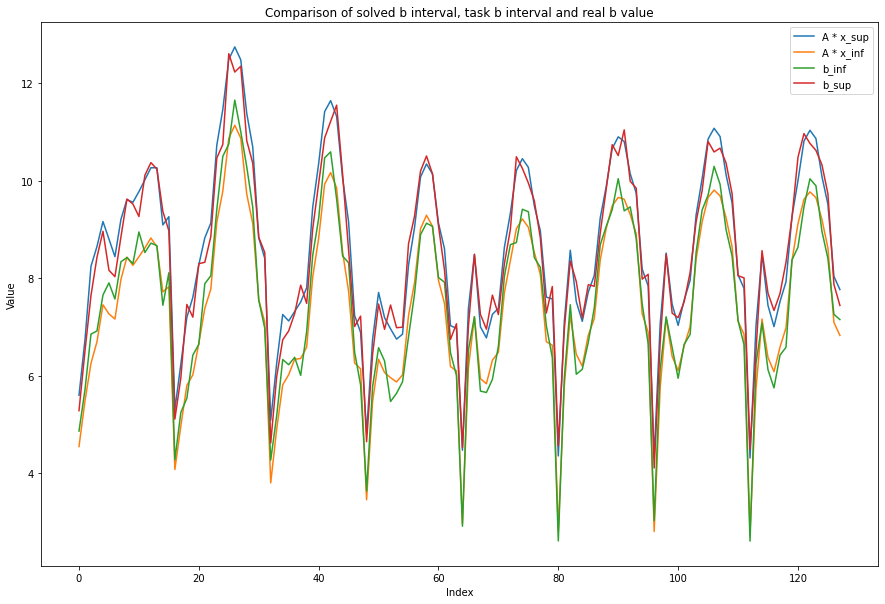

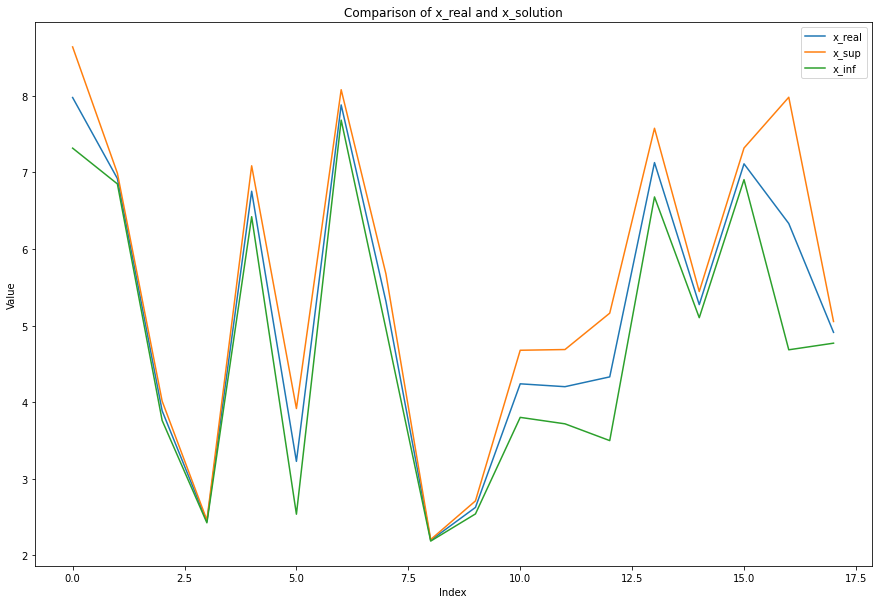

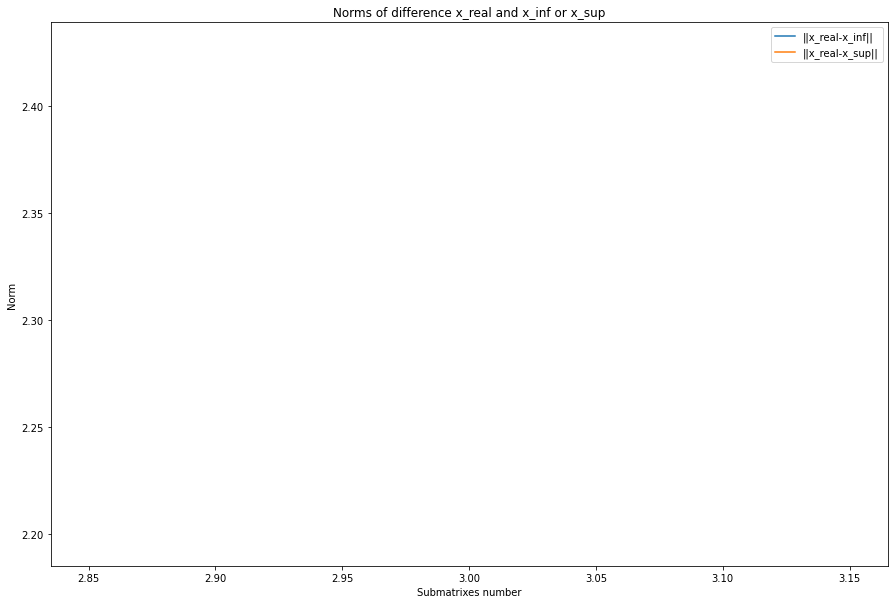

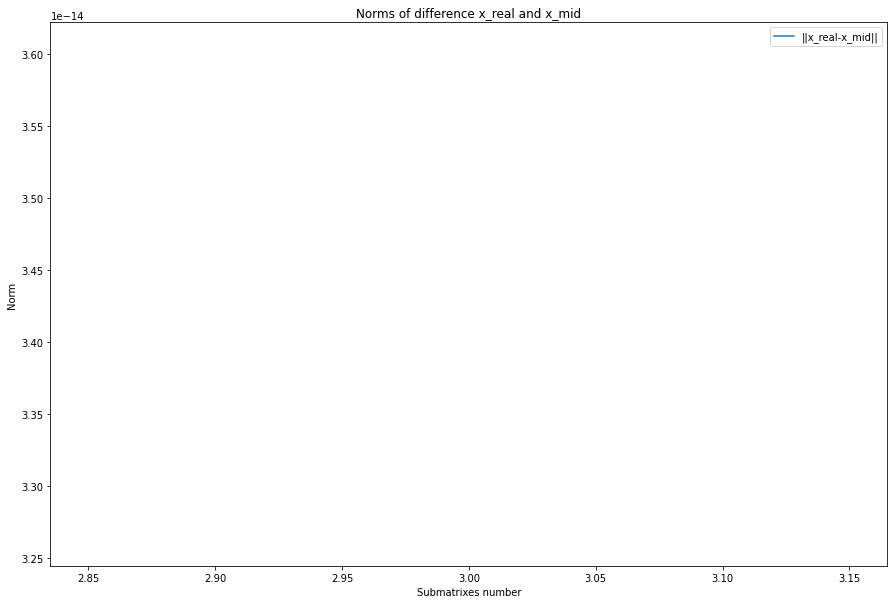

In [105]:
solve_task("matrix_n_phi_1.txt", [3], "1")